In [1]:
#this notebook is based on Igor Halperin's notebook: Trading Strategy based on PCA
#Please install: conda install -c desilinguist factor_analyzer==0.3.2

# Trading Strategy based on PCA

**For this project you will:**
- Read: https://www.researchgate.net/publication/228140014_Principal_Components_as_a_Measure_of_Systemic_Risk
- Understand how to use PCA to calculate a measure of market systemic risk (the absorption rato) as per this paper.
- Understand the use of the absorption ratio in a portfolio trading strategy (code provided in this notebook)

-Read: https://arxiv.org/abs/1808.01560
-Watch the video in: https://drive.google.com/drive/folders/1rAjuAQF9B6xEi39pKMnjdea-oTx0PGqL?usp=sharing
- Understand how to use an ARIMA+LSTM model to predict stock correlations as per this paper.
- Construct the ARIMA + LSTM model with the code provided in the appendix of this paper.
- Replace the covariance matrix in this notebook, cov_mat (see code below), with predicted_cov_mat. At present, cov_mat = ret_frame.cov().
-To construct predicted_cov_mat, calculate the covariance matrix as shown in PortfolioPresentationPart1.pptx slide 17 where the correlations are indicated with the Greek letter rho (see slide 13 for reference). Obtain the correlations by predicting them with the ARIMA + LSTM model. As per slide 17, you also need the variances indicated with the Greek letter sigma (see slide 9 for reference). A variance is just the covariance of an asset with itself.  You can predict these variances using the ARIMA + LSTM model also or you can just estimate them from historical data (as long as the lookbacks you use are consistent with the lookbacks used in the ARIMA + LSTM model). To predict the covariance of an asset with itself using an ARIMA + LSTM model, there is a shortcut: predict the squared returns series.
- Once you have replaced cov_mat with predicted_cov_mat, run this notebook and comment on the results: are they better than when using the original covariance matrix?
- You can use fewer stocks to limit the calculation time.

**Installation Instructions:**
- conda install -c desilinguist factor_analyzer

The absorption ratio was introduced by Kritzman and others in the 2010 paper, Principal Components as a Measure of Systemic Risk. The authors described the ratio as an implied measure of systemic risk that captures the extent to which markets are unified or tightly coupled.

The basic idea is to use building blocks of sub-assets to see how tightly a system of assets is trading. In this notebook we’ll use U.S. industries as the building blocks to examine the U.S. stock market. More specifically, we’ll examine linear combinations of U.S. industries  that explain the variance of the U.S. stock market. Principal Component Analysis solves this objective iteratively. PCA finds the linear combination of industries that explain the most amount of the market’s variance. Then it finds the next linear combination of industries that explain the most amount of left over variance (that is not explained by the first combination of industries). This process will be repeated until all of the variance has been explained. The absorption ratio gets its name from the idea of calculating how much of the market’s variance is “absorbed” by the first 20% of combinations of industries.

According to the paper, there are two steps to calculating a meaningful absorption ratio (AR). The first is to calculate the AR ratio and the second involves finding the standardized change of the AR ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change.

STEP 1: Formally, the ratio is defined by the variance absorbed by the first n eigenvectors:

![AR_Ratio.PNG](attachment:AR_Ratio.PNG)

The numerator equals the cumulative portion explained by the first n eigenvectors (i.e. the first n linear combinations of industries). And the denominator equals the total variance explained by all the assets (again, in this case industries). The paper suggests to set n to 1/5 of the total assets. But there are a variety of methods to find the significant stopping point for eigenvectors in PCA. You should try a number of settings for this parameter n.

 Basically you will see that  the first combination (the first eigenvector) of industries explains more than 50% of the total variance. This reading makes sense: the U.S. industries are mostly going to trade together because they’re driven by the same underlying factor, in this case, the vector of market driven betas which is usually captured by the first eigenvector. The second combination (eigenvector) of industries (possibly representing growth stocks vs value stocks) will add to our explanation of total variance (total risk), and the next one (possibly defensive stocks vs cyclical stocks), etc. until the explained variance is over 80%. This is our absorption ratio.
Note: the meaning of an eigenvector cannot be determined exactly

STEP 2: Having computed AR daily and put together an AR times series, we further follow M. Kritzman to make use of AR to define yet another measure: AR Delta. AR Delta is the standardized change of the absorption ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change In particular:

![AR_Ratio_ZValue.PNG](attachment:AR_Ratio_ZValue.PNG)

We use  𝐴𝑅 Delta  to build simple portfolio trading strategy.

### Keiser-Meyer-Olkin (KMO)

We have discussed in lecture that PCA can be used to filter "noise" away from data by the removal of some principal components, specifically those that have less importance because their eigenvalue is small compared to that of the principal components that we keep. This presupposes that the the eigenvalues that PCA outputs are NOT all going to be of similar magnitude. If the eigenvalue magnitudes are similar, that is an indication that the variables in the original data were largely uncorrelated with one another to begin with; meaning, each variable was contributing a valuable dimension, so it makes sense to keep all of them, not to get rid of some of them via PCA.  There is a rule of thumb that can be used to determine if PCA is redundant or not: if the average absolute value of the off diagonal elements of the correlation matrix of the orginal data is less than 0.3, then PCA is redundant for that data.  A more formal way making this determination is through the use of the Kaiser-Meyer-Olkin (KMO) measure.

We use the Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy (Kaiser,1970;
Kaiser and Rice,1974) to test the length of the shortest sliding window that a PCA could be
efficiently applied to. The KMO statistic compares the value of correlations between assets
(here industry ETFs) to those of the partial correlations.
If the investigated assets share more common variation,
the KMO will be close to 1. On the other hand, a KMO near 0 indicates little common variation
and the PCA will not extract much useful information.

The KMO statistic can also be used to assess the potential for diversification. Since the KMO
statistic measures the degree of common variation among the input assets,
one can expect less diversification opportunities (and higher market risk)
when the assets have more common variation, which means a high KMO test statistic.

As mentioned above, KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate for PCA.

See: 1. Kaiser, H. F. and Rice, J. (1974). Little jiffy. Educational and Psychological Measurement,
34(1):111–117. and 2. https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

In [2]:
import pandas as pd
import numpy as np
import sklearn.decomposition

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.model_selection
import pandas as pd
!pip install factor_analyzer
from factor_analyzer.factor_analyzer import calculate_kmo

#### Dataset:  daily prices of ETFs of 20 different industries  ####
For this exercise we will be working with 20 ETFs representing 20 different industries.
The following cell computes returns based on ETF price data. We obtain the data from WRDS as follows:

In [3]:
#1.Go to WRDS CRSP database and obtain the price and ticker data for the following industry ETFs:
#IYW IYJ IBB IGV IXP IYT VNQ PBS PBJ KCE KIE KBE XSD ITB ITA IHI IHF IHE IEZ FDN
#2. set the starting and ending dates as follows: 1/3/2007 and 12/31/2019
#3. Unstack the prices and save the unstacked price data into a csv file called:
# 20industries_ETF_prc_UNSTACKED.csv

In [4]:
import os
# load dataset
asset_prices = pd.read_csv('20industries_ETF_prc_UNSTACKED.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 20
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3272, 20)


,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,KCE,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
datadate,,,,,,,,,,,,,,,,,,,,
2007-01-03,54.67,65.36,77.64,44.62,63.70,83.4600,77.12,16.23,16.429,67.6344,57.08,58.63,49.06,41.18,53.48,50.78,53.78,53.3484,43.2000,22.2998
2007-01-04,55.57,65.39,78.84,45.40,64.16,83.8599,77.22,16.33,16.450,67.6500,57.12,58.61,50.11,40.79,53.42,50.94,53.75,53.9000,42.0644,23.2200
2007-01-05,55.12,64.94,78.85,44.99,63.16,82.6100,75.79,16.20,16.350,67.4900,56.66,58.02,49.25,40.38,53.17,50.75,53.35,53.6000,42.0600,22.9900
2007-01-08,55.32,65.15,78.96,45.20,63.75,82.8900,75.90,16.20,16.340,68.6000,56.69,58.17,49.32,39.54,53.76,51.25,53.72,53.6200,42.0899,22.9700
2007-01-09,55.65,65.19,78.91,45.20,63.72,83.1000,76.86,16.23,16.350,68.9100,56.48,58.05,49.56,39.61,53.71,51.58,53.08,53.8700,41.8300,22.9800


### Calculate daily returns ¶

In [5]:
asset_returns = asset_prices.pct_change(periods=1)
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,KCE,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
datadate,,,,,,,,,,,,,,,,,,,,
2007-01-04,0.016462,0.000459,0.015456,0.017481,0.007221,0.004792,0.001297,0.006161,0.001278,0.000231,0.000701,-0.000341,0.021402,-0.009471,-0.001122,0.003151,-0.000558,0.010340,-0.026287,0.041265
2007-01-05,-0.008098,-0.006882,0.000127,-0.009031,-0.015586,-0.014905,-0.018519,-0.007961,-0.006079,-0.002365,-0.008053,-0.010067,-0.017162,-0.010051,-0.004680,-0.003730,-0.007442,-0.005566,-0.000105,-0.009905
2007-01-08,0.003628,0.003234,0.001395,0.004668,0.009341,0.003389,0.001451,0.000000,-0.000612,0.016447,0.000529,0.002585,0.001421,-0.020802,0.011096,0.009852,0.006935,0.000373,0.000711,-0.000870
2007-01-09,0.005965,0.000614,-0.000633,0.000000,-0.000471,0.002533,0.012648,0.001852,0.000612,0.004519,-0.003704,-0.002063,0.004866,0.001770,-0.000930,0.006439,-0.011914,0.004662,-0.006175,0.000435
2007-01-10,0.008985,0.001534,0.004309,0.003540,-0.011142,0.002286,0.012881,0.001232,0.007951,0.015673,0.001239,0.001378,0.017958,0.000505,0.007634,0.002714,0.003391,-0.000371,-0.015061,0.006092


In [6]:
def normalize_returns(r_df):
    mean_r = r_df.mean(axis=0)
    sd_r = r_df.std(axis=0)
    normed_df = (r_df - mean_r) /sd_r
    return normed_df

In [7]:
normed_r = normalize_returns(asset_returns)
normed_r.iloc[:, :n_stocks_show].head()

,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,KCE,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
datadate,,,,,,,,,,,,,,,,,,,,
2007-01-04,1.188124,0.006221,0.793868,1.180974,0.584213,0.290918,0.051180,0.415470,0.101186,0.003972,0.025898,-0.023448,1.050519,-0.432476,-0.124127,0.212696,-0.077886,0.830709,-1.160044,2.666506
2007-01-05,-0.643716,-0.546687,-0.013245,-0.674605,-1.277347,-1.006712,-0.928184,-0.589853,-0.641238,-0.128270,-0.383558,-0.453157,-0.883524,-0.458249,-0.392560,-0.356087,-0.587440,-0.499629,-0.005862,-0.695129
2007-01-08,0.230898,0.215216,0.053529,0.284166,0.757249,0.198545,0.058826,-0.023145,-0.089520,0.830108,0.017885,0.105853,0.048455,-0.935263,0.797693,0.766654,0.476755,-0.002889,0.030086,-0.101553
2007-01-09,0.405192,0.017893,-0.053265,-0.042530,-0.043611,0.142153,0.612228,0.108683,0.033956,0.222439,-0.180146,-0.099524,0.221217,0.066283,-0.109652,0.484508,-0.918438,0.355871,-0.273454,-0.015801
2007-01-10,0.630398,0.087189,0.206939,0.205224,-0.914662,0.125875,0.623711,0.064578,0.774545,0.790663,0.051090,0.052515,0.877783,0.010136,0.536434,0.176604,0.214413,-0.065151,-0.665173,0.355830


In [8]:
def absorption_ratio(explained_variance_arr, n_components):
    """
    Calculate absorption ratio via PCA.
    Arguments:
    explained_variance_arr -- 1D np.array of explained variance by each pricincipal component, in descending order
    n_components -- an integer, a number of principal components to compute absorption ratio
    Formally, the ratio is defined by the variance absorbed by the first n eigenvectors
    The numerator equals the cumulative variance explained by the first n eigenvectors (=n_components)
    And the denominator equals the total variance
    Return:
    ar -- absorption ratio
    """
    ar = np.sum(explained_variance_arr[:n_components]) / np.sum(explained_variance_arr)
    return ar

In [9]:
stock_tickers = asset_returns.columns.values[:]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

lookback_window = 100 * 1   # in (days)
num_assets = len(stock_tickers)
step_size = 1          # days : 5 - weekly, 21 - monthly, 63 - quarterly

# require 0.8 variance to be explained.
var_threshold = 0.8

# fix 20% of principal components for absorption ratio calculation.
absorb_comp = int((1 / 5) * num_assets)


print('Lookback window = %d' % lookback_window)
print('Step size = %d' % step_size)
print('Variance Threshold = ', var_threshold)
print('Number of assets = %d' % num_assets)
print('Number of principal components = %d' % absorb_comp)

Lookback window = 100
Step size = 1
Variance Threshold =  0.8
Number of assets = 20
Number of principal components = 4


In [10]:
'''

return frame
  index     0 <------> 100   <--------------------------->     2100  <-------------------->  3272
            lookback        20 timesteps * 100days(one step)         predict AR for each day
            window
            
corresponding 
index in 
sigma/corr                0  <---------------------------->    2000  <-------------------->  3172



where  3272 = total datapoints number
       100  = lookback window
       100  =  one time step in samples for time-series prediction
       20   =  timestamps number in one sample of X    
'''

# indexes date on which to compute PCA
# in data sequence for predicting
time_step = 100
timestamp_num = 20

index_offset = time_step * timestamp_num
num_datapoints = len(asset_returns)
pca_ts_index = asset_returns.index[list(range(lookback_window + index_offset, num_datapoints, step_size))]

# allocate arrays for storing absorption ratio
pca_components = np.array([np.nan]* (num_datapoints - index_offset))
absorp_ratio = np.array([np.nan]*(num_datapoints - index_offset))
kmo = np.array([np.nan]*(num_datapoints - index_offset))

assert 'SPX' not in asset_returns.iloc[:lookback_window, :].columns.values, "By accident included SPX index"

print("Index offset is {}".format(index_offset))
print("Number of Datapoints is {}".format(num_datapoints))
print("Length of pca_components, absorp_ratio and kmo is {}".format(num_datapoints - index_offset - lookback_window))

Index offset is 2000
Number of Datapoints is 3271
Length of pca_components, absorp_ratio and kmo is 1171


# Prediction Model

In [11]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import pylab as pl
from pyramid.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter("ignore")

import os
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import statsmodels.stats

c:\Users\chuiy\miniconda3\envs\aps1052\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [12]:
def normalize_returns(r_df):
    mean_r = r_df.mean(axis=0)
    sd_r = r_df.std(axis=0)
    normed_df = (r_df - mean_r) /sd_r
    return normed_df

def rolling_corr(item1,item2):
    #import data
    stock_price_df = pd.read_csv("./20industries_ETF_prc_UNSTACKED.csv")
    pd.to_datetime(stock_price_df['datadate'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['datadate']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_pair.columns = [item1,item2]
    df_pair = normalize_returns(df_pair)
    df_pair = df_pair.ewm(halflife=100/12).mean()
    df_corr = df_pair[item1].rolling(window=lookback_window).corr(df_pair[item2])
    return df_corr

def corr_to_matrix(final_corr):
    correlation_matrix = np.zeros((num_assets, num_assets))
    correlation_values = []
    for i in range(len(final_corr)//5):
        correlation_values.append(final_corr[i*5:i*5+5].mean())
    correlation_values = np.array(correlation_values)
    
    ix = 0
    for i in range(num_assets):
        for j in range(num_assets-1, -1, -1):
            if i == j:
                correlation_matrix[i, j] = 1  # Set diagonal elements to 1
            elif i < j:
                correlation_matrix[i, j] = correlation_values[ix]
                ix += 1
            else:
                correlation_matrix[i, j] = correlation_matrix[j, i]
    return correlation_matrix

In [13]:
def double_tanh(x):
    return (2*K.tanh(x))


class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        
        self.__name__ = 'double_tanh'



class Model():
    def __init__(self, lstm_model=None):
        self.lstm_model = lstm_model
    
    
    def arima_predict(self, s):
        '''corr: 20 * 950'''
        model_110 = ARIMA(order=(1,1,0), method='mle', suppress_warnings=True)
        model_011 = ARIMA(order=(0,1,1), method='mle', suppress_warnings=True)
        model_111 = ARIMA(order=(1,1,1), method='mle', suppress_warnings=True)
        model_211 = ARIMA(order=(2,1,1), method='mle', suppress_warnings=True)
        model_210 = ARIMA(order=(2,1,0), method='mle', suppress_warnings=True)

        train_X = []; train_Y = []
        dev_X = []; dev_Y = []
        test1_X = []; test1_Y = []
        test2_X = []; test2_Y = []

        flag = 0

        prediction_20th = []
        residuals = []
        for i in range(950):
            c = 1
            try:
                model1 = model_110.fit(s[i])
                model = model1
                
                try:
                    model2 = model_011.fit(s[i])
                    
                    if model.aic() <= model2.aic() :
                        pass
                    else :
                        model = model2
                        
                    try :
                        model3 = model_111.fit(s[i])
                        if model.aic() <= model3.aic() :
                            pass
                        else :
                            model = model3
                    except :
                        try:
                            model4 = model_211.fit(s[i])
                            
                            if model.aic() <= model4.aic() :
                                pass
                            else:
                                model = model4
                        except:
                            try:
                                model5 = model_210.fit(s[i])
                                
                                if model.aic() <= model5.aic():
                                    pass
                                else :
                                    model = model5
                            except :
                                pass
                        
                except:
                    try:
                        model3 = model_111.fit(s[i])

                        if model.aic() <= model3.aic() :
                            pass
                        else :
                            model = model3
                    except :
                        try:
                            model4 = model_211.fit(s[i])
                            
                            if model.aic() <= model4.aic() :
                                pass
                            else:
                                model = model4
                        except:
                            try:
                                model5 = model_210.fit(s[i])
                                
                                if model.aic() <= model5.aic():
                                    pass
                                else :
                                    model = model5
                            except :
                                pass
                    
            except:
                try:
                    model2 = model_011.fit(s[i])
                    model = model2
                
                    try :
                        model3 = model_111.fit(s[i])
                        
                        if model.aic() <= model3.aic():
                            pass
                        else:
                            model = model3
                    except :
                        try:
                            model4 = model_211.fit(s[i])
                            
                            if model.aic() <= model4.aic() :
                                pass
                            else:
                                model = model4
                        except:
                            try:
                                model5 = model_210.fit(s[i])
                                
                                if model.aic() <= model5.aic():
                                    pass
                                else :
                                    model = model5
                            except :
                                pass
                
                except :
                    try:
                        model3 = model_111.fit(s[i])
                        model = model3
                    except :
                        try:
                            model4 = model_211.fit(s[i])
                            
                            if model.aic() <= model4.aic() :
                                pass
                            else:
                                model = model4
                        except:
                            try:
                                model5 = model_210.fit(s[i])
                                
                                if model.aic() <= model5.aic():
                                    pass
                                else :
                                    model = model5
                            except :
                                flag = 1
                                print(str(c) + " FATAL ERROR")
                                break
                


                
            predictions = list(model.predict_in_sample())
            #pad the first time step of predictions with the average of the prediction values
            #so as to match the length of the s[i] data
            predictions = [np.mean(predictions)] + predictions # [21]   * 950 iterations
            
            prediction_20th.append(predictions[-1])
            
            residual = pd.Series(np.array(s[i]) - np.array(predictions))
            residuals.append(np.array(residual))
            
        residuals = np.array(residuals)
        prediction_20th = np.array(prediction_20th)

        return residuals, prediction_20th
    
    
    def lstm_predict(self, residual):
        model = load_model(self.lstm_model)

        residual = residual.reshape((950,20,1))
        resid_predictions = model.predict(residual)

        return resid_predictions

    def compute_predict_corr_matrix(self, residual, prediction):
        corr = residual+prediction
        return corr_to_matrix(corr)

    def predict_corr_from_s(self, s):
        residual, prediction = self.arima_predict(s)
        r = self.lstm_predict(residual)
        mat = self.compute_predict_corr_matrix(r, prediction)
        return mat
        

In [14]:
corr = []
sigma = []
for ix in range(lookback_window, num_datapoints):
    ret_frame = normalize_returns(asset_returns.iloc[ix - 100:ix, :])
    ret_frame_kmo = ret_frame.copy(deep=True)
    ret_frame = ret_frame.ewm(halflife=10).mean()
    corr_mat = ret_frame.corr()
    curr_sigma = ret_frame.std(axis=0)
    corr.append(corr_mat)
    sigma.append(curr_sigma)

corr = np.array(corr)   # (3171 * 20 * 20)
sigma = np.array(sigma) # (3171 * 20)


In [56]:
def format_corr(prev_corr):
    result  = []
    for i in range(20):
        new = []

        for row in range(num_assets):
            for col in range(num_assets-1, row, -1):
                for j in range(i*5, i*5+5):
                    curr = prev_corr[j]
                    new.append(curr[row][col])
        result.append(new)
    result = np.array(result)
    result = np.transpose(result)
    return result

def predict_corr(prev_corr):
    m = Model(lstm_model='./models/hybrid_LSTM/epoch124.h5')
    return m.predict_corr_from_s(prev_corr)


**What this loop does**
- on each loop iteration:
    - fits PCA to **ret_frame**
    - uses fitted pca model to pass values to absorption_ratio().
    - computes the number of principal components it takes to explain at least **var_threshold** of variance. The result of this calculation goes into **pca_components[ik]**. The result of the absorption ratio calculation goes into **absorp_ratio[ik]**.  The result of the KMO statistic calculation goes into **kmo[ik]**.

In [17]:
get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})
ik = 0
for ix in range(index_offset, num_datapoints -  lookback_window):
    if ik == 0 or ik % 10 == 0:
        prev_ix = [ix - 20 * i for i in range(100, 0, -1)]
        prev_corr = corr[prev_ix]
        prev_corr_format = format_corr(prev_corr)
        predicted_corr_mat = predict_corr(prev_corr_format)
        predicted_cov_mat = statsmodels.stats.moment_helpers.corr2cov(predicted_corr_mat, sigma[ix])

        eigenvalues, eigenvectors = np.linalg.eig(predicted_cov_mat)
        sorted_indices = np.argsort(eigenvalues)[::-1]

        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        explained_variance = np.cumsum(explained_variance_ratio)

        ar = np.sum(explained_variance_ratio[:absorb_comp]) / np.sum(explained_variance_ratio)
        absorp_ratio[ik] = ar

        ret_frame = normalize_returns(asset_returns.iloc[ix:ix+100, :])
        ret_frame_kmo = ret_frame.copy(deep=True)
        kmo_per_variable, kmo_total=calculate_kmo(ret_frame_kmo)
        kmo[ik] = kmo_total
        pca_components[ik] = np.where(np.logical_not(explained_variance < var_threshold))[0][0] + 1

    else:
        absorp_ratio[ik] = absorp_ratio[ik-1]
        pca_components[ik] = pca_components[ik-1]
        kmo[ik] = kmo[ik-1]
    np.save('./my_data/result/ar'+str(ik), absorp_ratio)
    np.save('./my_data/result/pca'+str(ik), pca_components)
    np.save('./my_data/result/kmo'+str(ik), kmo)
    ik += 1

In [59]:
absorp_ratio = np.load('./my_data/result/ar1170.npy')
pca_components= np.load('./my_data/result/pca1170.npy')
kmo = np.load('./my_data/result/kmo1170.npy')

In [60]:
ts_pca_components = pd.Series(pca_components, index=pca_ts_index)
ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)


The value of the KMO statistic should be between .6 and 1. Change the number of years (with a year defined in terms of 252 trading days) in the lookback window to get the minimum KMO below to be close to 0.79. The KMO statistic and AR tell us similar information:

In [61]:
np.amin(kmo)

0.786576635680853

In [18]:
# require 0.8 variance to be explained. How many components are needed?
print('number of components needed to explain 0.8 variance: ', pca_components[len(pca_components)-1])

number of components needed to explain 0.8 variance:  11.0


In [58]:
# fix 20% of principal components for absorption ratio calculation. How much variance (in %) do they explain?
print('variance explained by 20% of principal components: ', explained_variance[absorb_comp-1])

variance explained by 20% of principal components:  0.563177862302382


<AxesSubplot:>

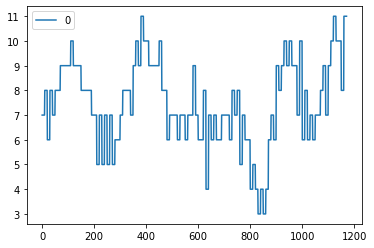

In [62]:
pd.DataFrame(pca_components).plot()

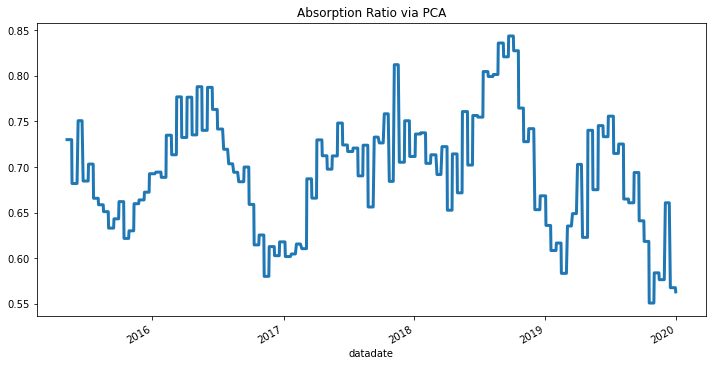

In [63]:
ts_absorb_ratio.plot(figsize=(12,6), title='Absorption Ratio via PCA', linewidth=3)
plt.savefig("Absorption_Ratio_20i.png", dpi=900)

STEP 2:
Having computed the Absorption Ratio as a daily times series, we define AR Delta. AR Delta is the standardized change of the absorption ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change
In particular:
$$ AR\delta = \frac{AR_{15d} - AR_{1y}}{ AR\sigma_{1y}}$$
We use  $AR\delta$ to build simple portfolio trading strategy

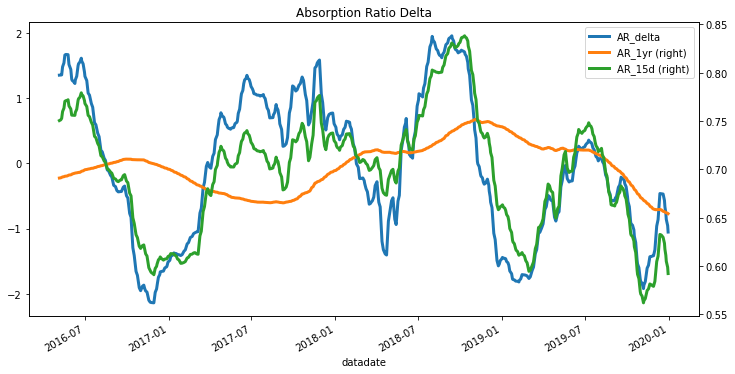

In [64]:
# following Kritzman and computing AR_delta = (15d_AR -1yr_AR) / sigma_AR
ts_ar = ts_absorb_ratio
ar_mean_1yr = ts_ar.rolling(252).mean()
ar_mean_15d = ts_ar.rolling(15).mean()
ar_sd_1yr = ts_ar.rolling(252).std()
ar_delta = (ar_mean_15d - ar_mean_1yr) / ar_sd_1yr  # standardized shift in absorption ratio

df_plot = pd.DataFrame({'AR_delta': ar_delta.values, 'AR_1yr': ar_mean_1yr.values, 'AR_15d': ar_mean_15d.values},
                       index=ts_ar.index)
df_plot = df_plot.dropna()
if df_plot.shape[0] > 0:
    df_plot.plot(figsize=(12, 6), title='Absorption Ratio Delta', linewidth=3, secondary_y=['AR_1yr','AR_15d'])

#### Part 3 (AR Delta Trading Strategy)

Here we implement get_weight() function

The AR Delta trading strategy forms a portfolio of EQ (equities=stocks) and FI (fixed income=bonds), following these simple rules:

* __$ -1\sigma < AR\delta < +1\sigma $__	 50% / 50% weights for EQ / FI
* __$ AR\delta > +1\sigma $__	             0% / 100% weights for EQ / FI
* __$ AR\delta < -1\sigma $__	             100% / 0% weights for EQ / FI

Here we compute AR Delta strategy weights using data from the same data set. As expected, the average number of trades per year is very low.

In [65]:
def get_weight(ar_delta):
    '''
    Calculate EQuity / FIncome portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta

    Return:
        wgts -- a vector of portfolio weights
    '''
    wgts = [0.0, 0.0] # replace with your own calculation here
    if ar_delta < -1:
        wgts = [1, 0]
    elif ar_delta > 1:
        wgts = [0, 1]
    else:
        wgts = [.5, .5]
    return wgts

In [66]:
#Average trades per year
ar_delta_data = ar_delta[251:]

rebal_dates = np.zeros(len(ar_delta_data))
wgts = pd.DataFrame(data=np.zeros((len(ar_delta_data.index), 2)), index=ar_delta_data.index, columns=('EQ', 'FI'))

prtf_wgts = get_weight(ar_delta_data.values[0])
wgts.iloc[0, :] = prtf_wgts
for ix in range(1, len(ar_delta_data)):
    prtf_wgts = get_weight(ar_delta_data.values[ix])
    wgts.iloc[ix, :] = prtf_wgts
    if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:
        prtf_wgts = wgts.iloc[ix, :]
        rebal_dates[ix] = 1

ts_rebal_dates = pd.Series(rebal_dates, index=ar_delta_data.index)
ts_trades_per_year = ts_rebal_dates.groupby([ts_rebal_dates.index.year]).sum()
print('Average number of trades per year %.2f' % ts_trades_per_year.mean())

Average number of trades per year 4.50


Now that weights have been determined, run the re-balancing strategy using time series of returns and compute
 - sharpe of the strategy
 - strategy annualized return
 - strategy annualized volatility

Contrast this with 50 / 50 Equity / Fixed Income ETF strategy performance using the same performance metrics. Use VTI as Equity and AGG as Fixed Income assets.

In [67]:
#1. Go to WRDS CRSP database and obtain the Holding Period Return and ticker for the following industry ETFs:
# VTI AGG
#the holding period return includes dividends, coupon flows etc.
#2. set the starting and ending dates as follows: 1/3/2007 and 12/31/2019
#3. Unstack the holding period returns and save the unstacked returns data into a csv file called:
# AGG_VTI_UNSTACKED_adjusted_returns.csv

In [68]:
#These are adjusted PERCENT returns of AGG and VTI from WRDS CRSP, including distibutions, coupons, dividends etc.
etf_percent_returns = pd.read_csv('AGG_VTI_UNSTACKED_adjusted_returns.csv')
etf_percent_returns["datadate"]=pd.to_datetime(etf_percent_returns['datadate'])
etf_percent_returns.set_index(['datadate'], inplace=True)
etf_log_returns = np.log(etf_percent_returns + 1)
#decide which return you are going to use by uncommenting a or b below (only a or b is correct, not both):
#a:
#etf_returns = etf_log_returns.copy()
#b:
etf_returns = etf_percent_returns.copy()

In [69]:
n_stocks_show = 2
print('Asset holding period returns shape', etf_returns.shape)
etf_returns.iloc[:, :n_stocks_show].head()

Asset holding period returns shape (3271, 2)


,AGG,VTI
datadate,,
2007-01-03,0.002106,-0.001854
2007-01-04,0.002102,0.002001
2007-01-05,-0.000699,-0.007916
2007-01-08,0.000600,0.003666
2007-01-09,0.000000,0.000000


#### Part 4 (Calculate performance of backtested strategy)

Here we implement function backtest_strategy which given a DataFrame of strategy weights and a DataFrame asset returns annualized return, volatility and Sharpe ratio of a strategy. Our solution has higher anualized returns and shape ratio and similar anualized volatility, compared with non-prediction AR delta strategy 

In [96]:
def backtest_strategy(strat_wgts, asset_returns, label, periods_per_year = 252):
    '''
    Calculate portfolio returns and cumulative returns and portfolio strategy performance
    Arguments:

    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year

    Return:
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    before returning plot the cumulative return of the EWM+AGG portfolio
    '''
    df_all=pd.merge(strat_wgts,asset_returns, left_index=True, right_index=True, how='inner')
    df_all['EQ_part'] = df_all.EQ*df_all.VTI
    df_all['FI_part'] = df_all.FI*df_all.AGG
    df_all['PORT_ret']=df_all.EQ_part+df_all.FI_part

    average_arithmetic_return = df_all.PORT_ret.mean()
    annualized_return = average_arithmetic_return*periods_per_year
    annualized_vol = df_all.PORT_ret.std()*np.sqrt(periods_per_year)
    annualized_sharpe = (df_all.PORT_ret.mean()/df_all.PORT_ret.std())*np.sqrt(periods_per_year) #classic definition
    #before returning plot the cumulative return of the EWM+AGG portfolio
    df_all['PORT_ret'] = df_all.PORT_ret + 1
    df_all['Cum_PORT_ret'] = df_all.PORT_ret.cumprod()-1+1
    df_all['Cum_PORT_ret'].plot(label=label)
    return annualized_return, annualized_vol, annualized_sharpe, df_all['Cum_PORT_ret']


In [112]:
print(Cum_PORT_ret_ar)

datadate
2016-05-06    0.998470
2016-05-09    0.999100
2016-05-10    0.999550
2016-05-11    0.999550
2016-05-12    0.998650
                ...   
2019-12-24    1.457764
2019-12-26    1.461936
2019-12-27    1.462244
2019-12-30    1.458279
2019-12-31    1.462121
Name: Cum_PORT_ret, Length: 920, dtype: float64


Absorption Ratio strategy: 0.10705357173913044 0.07727830421127814 1.3852991836679929
Equally weighted: 0.0896055847826087 0.0613439064207015 1.4607088138157736


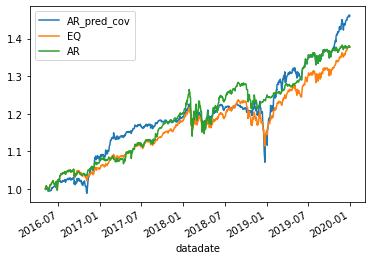

In [125]:
ann_ret, ann_vol, sharpe, Cum_PORT_ret_ar = backtest_strategy(wgts, etf_returns, 'AR_pred_cov')
print('Absorption Ratio strategy:', ann_ret, ann_vol, sharpe)


eq_wgts = wgts.copy()
eq_wgts.iloc[:, ] = 0.5
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt, Cum_PORT_ret_eq_wgt = backtest_strategy(eq_wgts, etf_returns, 'EQ')
print('Equally weighted:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)


Cum_PORT_ret = pd.read_csv('Cum_PORT_ret.csv')  # generated from baseline.ipynb
Cum_PORT_ret = pd.Series(np.array(Cum_PORT_ret)[:, 1], index=Cum_PORT_ret_ar.index)
Cum_PORT_ret.plot(label='AR')
plt.legend()
